# Classification on imbalanced data: Adjusting biases

How to classify an imbalanced dataset where one class outnumbers another. The data is from the Credit Card Fraud Detection dataset [on Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). There are a total 284,807 transactions from which to detect a 492 fraudulent transactions.


In [ ]:
import os, tempfile
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

##Load and preprocess data

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [ ]:
# Load the data set with Pandas
df = pd.read_csv("creditcard.csv")
df.head() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# View data metrics
df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# Examine class label imbalance
neg, pos = np.bincount(df['Class']) # Count number of occurrences of each value in array of non-negative ints
total = neg + pos
print('Targets:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Targets:
    Total: 284807
    Positive: 492 (0.17% of total)



## Clean, split and normalize the data

In [ ]:
clean_df = df.copy()
clean_df.pop('Time') # Drop the Time column
clean_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
# Take the log of the 'Amount' column to reduce its range
eps = 0.001 # 0 => 0.1¢
clean_df['Log Amount'] = np.log(clean_df.pop('Amount')+eps)
clean_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


In [ ]:
# Split and shuffle the dataframe (shuffle=True by default)
train_df, test_df = train_test_split(clean_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)
train_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Amount
274414,-4.419894,-2.609621,0.013230,-0.756957,1.071922,1.597737,3.582200,-1.489885,0.912482,0.584537,...,-0.995523,1.652549,1.112422,-1.276786,1.375306,0.074903,0.092790,-1.545690,0,6.146909
102332,-1.235166,2.399475,-0.877735,0.979887,-0.408141,-0.725765,-0.783096,-2.063300,-1.122150,-0.461134,...,-1.051884,1.073324,0.339711,0.410822,-0.638617,-0.427094,0.269699,0.203218,0,1.607636
54600,0.456750,-0.790355,-0.189645,1.413018,-0.326623,-0.240577,0.685180,-0.103289,-0.517607,0.035363,...,0.280240,0.027217,-0.366369,0.237362,0.459352,-0.380650,-0.052959,0.067917,0,5.896607
260622,2.311525,-1.391199,-1.014900,-1.673288,-0.999377,-0.198689,-1.217713,-0.115086,-1.117511,1.536962,...,-0.183499,-0.019145,0.233604,0.254236,-0.179455,-0.181605,0.019998,-0.043410,0,2.944492
166921,2.118056,-0.077916,-1.599640,-0.029186,0.651407,-0.087880,0.104316,-0.144418,0.257437,0.221641,...,-0.319076,-0.774098,0.150093,-1.364631,-0.119170,0.260784,-0.071067,-0.082468,0,-0.115411


In [ ]:
# Create label numpy arrays
train_labels = np.array(train_df.pop('Class')) 
bool_train_labels = train_labels != 0 # To use for plots later on
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_labels[3190:3200], bool_train_labels[3190:3200]

(array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 array([False, False, False, False, False, False, False,  True, False,
        False]))

In [ ]:
# Create feature numpy arrays
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

train_features[0]

array([-4.41989353, -2.60962127,  0.0132301 , -0.75695662,  1.07192184,
        1.5977369 ,  3.58219983, -1.48988471,  0.91248164,  0.58453672,
        1.63673585, -0.5358952 , -1.20467207, -0.6511145 ,  1.13655037,
       -0.35257814, -0.92577091, -0.93366404, -0.95011244, -3.52238589,
       -0.99552301,  1.65254879,  1.11242238, -1.27678575,  1.37530598,
        0.07490303,  0.09279032, -1.54569046,  6.14690939])

In [ ]:
# Normalize the data
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features) # scale and learn the scaling parameters train_features

# fit only train_features to prevent data leakage
val_features = scaler.transform(val_features) # Normalize by centering and scaling
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5) # In interval [-5, 5] turn <-5 to -5, and >5 to 5
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)
print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


## Plot the data distribution

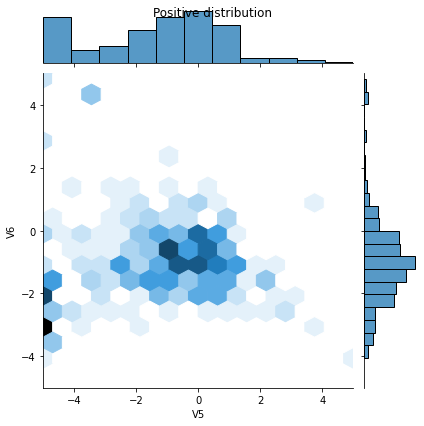

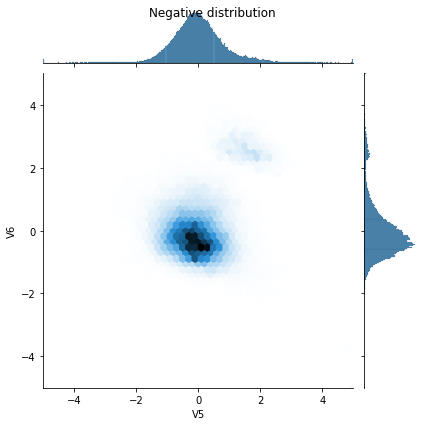

In [ ]:
pos_df = pd.DataFrame(train_features[bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns) # '~' -> Bitwise NOT

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Negative distribution");

In [ ]:
# Define metrics (Accuracy is not a helpful metric since near 100% accuracy is achieved by only predicting False)
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'), # ROC Area Under the Curve
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

## Build model function

In [ ]:
def make_model(metrics=METRICS, output_bias=None): # bias initialization parameter
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([
      keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)), # 29 targets
      keras.layers.Dropout(0.5), # not active on evaluation set
      keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias), # fraud or not
  ])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                loss='binary_crossentropy',
                metrics=metrics)

  return model

In [ ]:
# Model instance
model = make_model()

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 16)                480       
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Test the model on imbalanced data
model.predict(train_features[:10])

1/1 [==============================] - 0s 57ms/step


array([[4.9943253e-02],
       [5.1975113e-01],
       [1.4802235e-01],
       [4.1752666e-01],
       [8.0408484e-01],
       [1.0994496e-01],
       [2.1322873e-01],
       [5.9357595e-01],
       [4.1040295e-01],
       [7.1001408e-04]], dtype=float32)

##Adjust the initial bias

The test shows that initial guesses are poor since the data is imbalanced (should be about `math.log(2) = 0.69314`). To help initial convergence set the output layer's bias to reflect imbalances, so the model won't spend the first epochs on learning that positive examples are unlikely. 

In [ ]:
# Evaluate training data
EPOCHS = 100
BATCH_SIZE = 2048 # ensures each batch has a chance of containing a few positive samples

results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6932


In [ ]:
# Create adjusted bias (See "init well" t.ly/2wJN)
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [ ]:
# Test the model on adjusted bias 
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - 0s 99ms/step


array([[1.3320347e-03],
       [5.5033463e-04],
       [1.2141666e-03],
       [5.3803078e-03],
       [7.4696407e-04],
       [7.8387040e-04],
       [2.2878239e-03],
       [2.2384557e-03],
       [8.1073184e-04],
       [3.9446750e-06]], dtype=float32)

In [ ]:
# Evaluate on better initial guesses
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0161


In [ ]:
# Save initial weights to be loaded before each training for comparative results
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')# Creates and returns a unique temporary directory
model.save_weights(initial_weights)

## Compare the losses between zero and adjusted bias initialization

In [ ]:
model = make_model()
model.layers[-1].bias.assign([0.0]) # zero bias initialization
zero_bias_history = model.fit(train_features,
                              train_labels,
                              batch_size=BATCH_SIZE,
                              epochs=20,
                              validation_data=(val_features, val_labels), 
                              verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights) # correct bias initialization 
adjusted_bias_history = model.fit(train_features,
                                  train_labels,
                                  batch_size=BATCH_SIZE,
                                  epochs=20,
                                  validation_data=(val_features, val_labels), 
                                  verbose=0)

In [ ]:
# Dynamically change the default runtime configuration (rc) settings
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
def plot_loss(history, label, n):
  # A log scale on y-axis shows the range of values
  plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val ' + label, linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

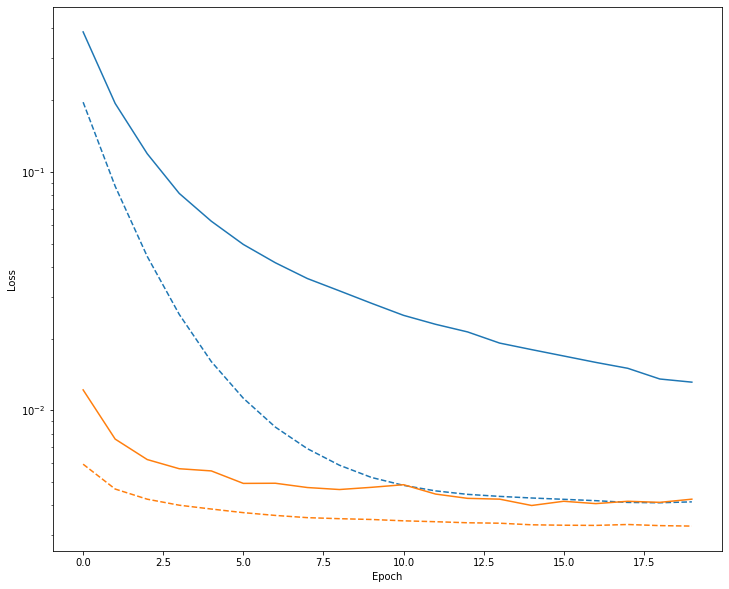

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(adjusted_bias_history, "Adjusted Bias", 1)

## Create EarlyStopping callback

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', # monitor precision-recall curve
                                                  verbose=1,
                                                  patience=10,
                                                  mode='max',
                                                  restore_best_weights=True)

## Train the model

In [ ]:
model = make_model()
model.load_weights(initial_weights)
history = model.fit(train_features,
                    train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=[early_stopping],
                    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 4s 19ms/step - loss: 0.0122 - tp: 86.0000 - fp: 31.0000 - tn: 227419.0000 - fn: 309.0000 - accuracy: 0.9985 - precision: 0.7350 - recall: 0.2177 - auc: 0.7383 - prc: 0.2732 - val_loss: 0.0058 - val_tp: 31.0000 - val_fp: 4.0000 - val_tn: 45487.0000 - val_fn: 47.0000 - val_accuracy: 0.9989 - val_precision: 0.8857 - val_recall: 0.3974 - val_auc: 0.8838 - val_prc: 0.6977
Epoch 2/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0074 - tp: 128.0000 - fp: 27.0000 - tn: 181932.0000 - fn: 189.0000 - accuracy: 0.9988 - precision: 0.8258 - recall: 0.4038 - auc: 0.8580 - prc: 0.5078 - val_loss: 0.0047 - val_tp: 41.0000 - val_fp: 4.0000 - val_tn: 45487.0000 - val_fn: 37.0000 - val_accuracy: 0.9991 - val_precision: 0.9111 - val_recall: 0.5256 - val_auc: 0.8973 - val_prc: 0.7419
Epoch 3/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0060 - tp: 149.0000 - fp: 26.0000 - tn: 181933.0000 - fn: 168.0000 - accuracy: 

##Plot metrics on the training and validation sets


In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

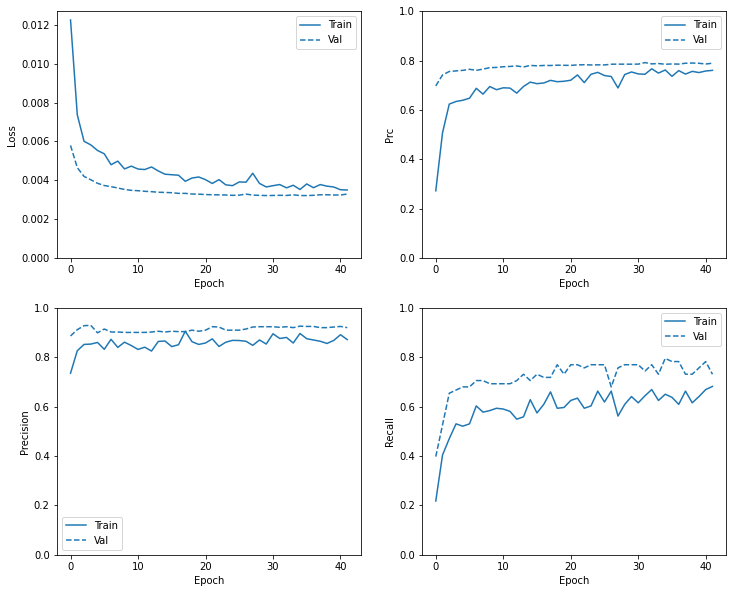

In [ ]:
plot_metrics(history)

## Evaluate metrics


In [ ]:
train_preds = model.predict(train_features, batch_size=BATCH_SIZE)
test_preds = model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 2ms/step


In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0026720480527728796
tp :  71.0
fp :  7.0
tn :  56858.0
fn :  26.0
accuracy :  0.9994206428527832
precision :  0.9102563858032227
recall :  0.7319587469100952
auc :  0.9326764345169067
prc :  0.8265256285667419

Legitimate Transactions Detected (True Negatives):  56858
Legitimate Transactions Incorrectly Detected (False Positives):  7
Fraudulent Transactions Missed (False Negatives):  26
Fraudulent Transactions Detected (True Positives):  71
Total Fraudulent Transactions:  97


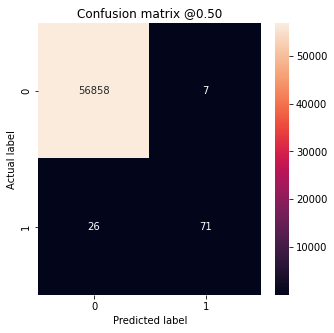

In [ ]:
# Evaluate model on the test set
results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, results): # tuple the values
  print(name, ': ', value)
print()

#  Call confusion matrix plot function
plot_cm(test_labels, test_preds)

In [ ]:
# Plot the ROC: shows the model's performance range  by tuning the output threshold
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

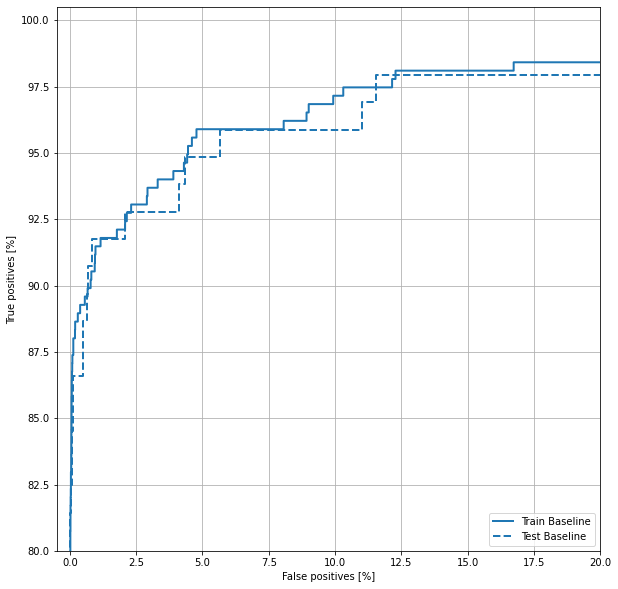

In [ ]:
plot_roc("Train Baseline", train_labels, train_preds, color=colors[0])
plot_roc("Test Baseline", test_labels, test_preds, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [ ]:
# Plot the AUPRC: the area under the interpolated precision-recall curve (average precision of the model)
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

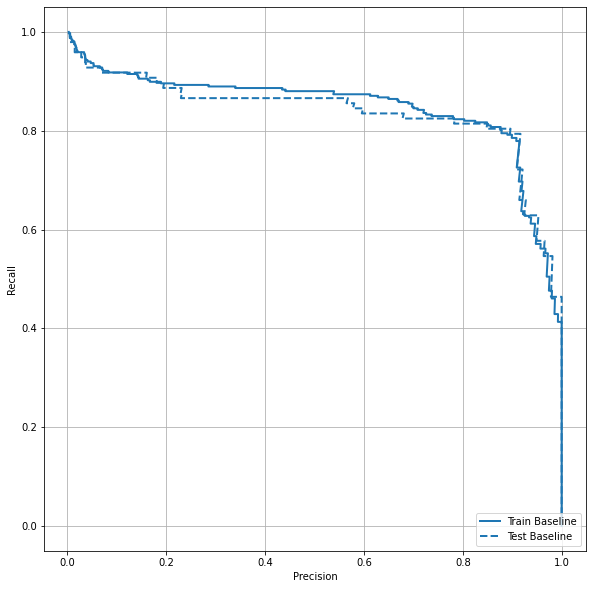

In [ ]:
plot_prc("Train Baseline", train_labels, train_preds, color=colors[0])
plot_prc("Test Baseline", test_labels, test_preds, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

## Calculate class weights

In [ ]:
# The classifier has to put more weight on positive examples given the few available samples  
weight_for_0 = (1 / neg) * (total * 0.5) # Scale by half to keep a similar loss magnitude
weight_for_1 = (1 / pos) * (total * 0.5)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


## Train a model with adjusted class weights

Using `class_weights` changes the range of the loss which may affect training stability depending on the optimizer. Optimizers like `tf.keras.optimizers.SGD` may fail (step size depends on gradient magnitude). `tf.keras.optimizers.Adam` is unaffected by the scaling change but the total losses between the two models are not comparable.

In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(train_features,
                                      train_labels,
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS,
                                      callbacks=[early_stopping],
                                      validation_data=(val_features, val_labels),
                                      class_weight=class_weight) # Class weights

Epoch 1/100
90/90 [==============================] - 4s 21ms/step - loss: 2.4507 - tp: 126.0000 - fp: 108.0000 - tn: 238716.0000 - fn: 288.0000 - accuracy: 0.9983 - precision: 0.5385 - recall: 0.3043 - auc: 0.7650 - prc: 0.2748 - val_loss: 0.0067 - val_tp: 39.0000 - val_fp: 4.0000 - val_tn: 45487.0000 - val_fn: 39.0000 - val_accuracy: 0.9991 - val_precision: 0.9070 - val_recall: 0.5000 - val_auc: 0.8758 - val_prc: 0.6543
Epoch 2/100
90/90 [==============================] - 1s 7ms/step - loss: 1.0897 - tp: 167.0000 - fp: 229.0000 - tn: 181730.0000 - fn: 150.0000 - accuracy: 0.9979 - precision: 0.4217 - recall: 0.5268 - auc: 0.8585 - prc: 0.4101 - val_loss: 0.0075 - val_tp: 56.0000 - val_fp: 10.0000 - val_tn: 45481.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8485 - val_recall: 0.7179 - val_auc: 0.8949 - val_prc: 0.7003
Epoch 3/100
90/90 [==============================] - 1s 7ms/step - loss: 0.8131 - tp: 207.0000 - fp: 430.0000 - tn: 181529.0000 - fn: 110.0000 - accur

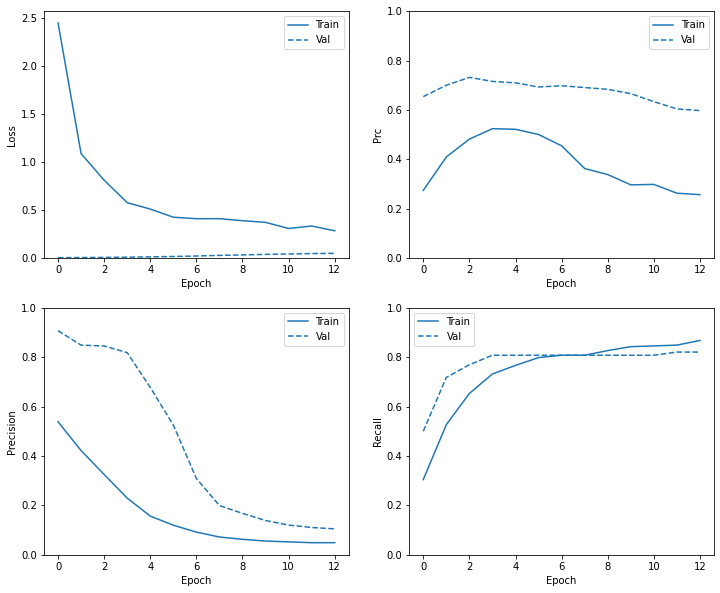

In [ ]:
# Plot histories
plot_metrics(weighted_history)

In [ ]:
# Evaluate metrics
train_preds_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_preds_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 2ms/step


loss :  0.010311233811080456
tp :  76.0
fp :  16.0
tn :  56849.0
fn :  21.0
accuracy :  0.9993504285812378
precision :  0.8260869383811951
recall :  0.7835051417350769
auc :  0.9342051148414612
prc :  0.6752803325653076

Legitimate Transactions Detected (True Negatives):  56849
Legitimate Transactions Incorrectly Detected (False Positives):  16
Fraudulent Transactions Missed (False Negatives):  21
Fraudulent Transactions Detected (True Positives):  76
Total Fraudulent Transactions:  97


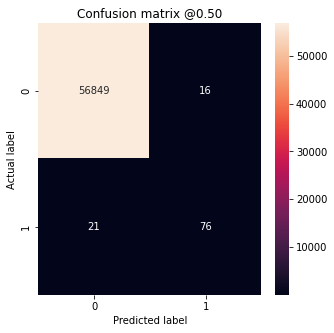

In [ ]:
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_preds_weighted)

## Evaluate metrics

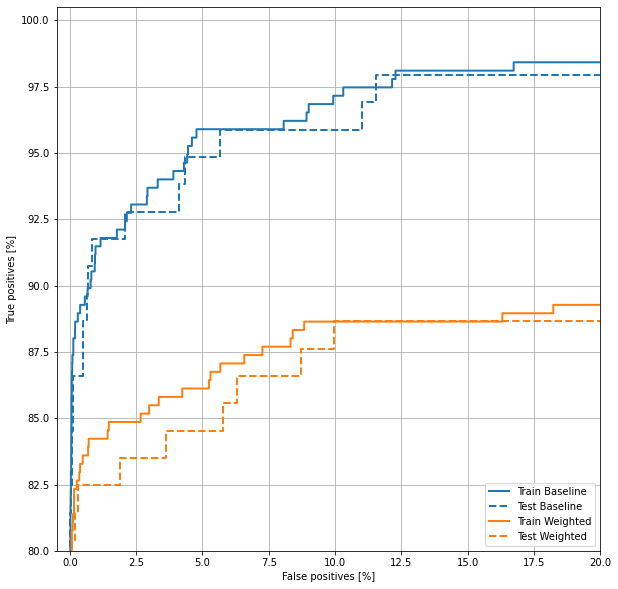

In [ ]:
# Compare ROCs
plot_roc("Train Baseline", train_labels, train_preds, color=colors[0])
plot_roc("Test Baseline", test_labels, test_preds, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_preds_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_preds_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

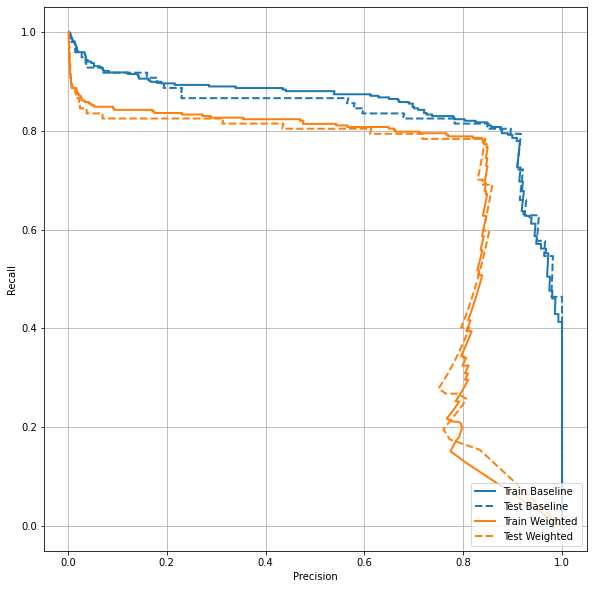

In [ ]:
# Compare AUPRCs 
plot_prc("Train Baseline", train_labels, train_preds, color=colors[0])
plot_prc("Test Baseline", test_labels, test_preds, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_preds_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_preds_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

# Classification on imbalanced data: Oversampling the minority class

Another techniques for dealing with imbalanced data is to resample the dataset by oversampling the minority class.

In [ ]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [ ]:
# Produce balanced examples with tf.data by starting with a positive and a negative dataset, and merge them
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
# Each dataset provides (feature, label) pairs
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-0.20384414 -0.44907615 -1.31351632 -0.14401019  1.36130104 -1.06604715
 -0.06161823 -0.83446386  0.6888475   0.20054663  0.24960554 -0.07369316
 -2.22647143  1.10635986 -0.84659676 -1.03820584 -0.26433989  0.91626202
  0.58483572 -1.32484003  1.89303353  2.96305712  0.2976122   1.27859265
 -1.67090898 -0.41729014  0.87758857  0.09988706 -1.634035  ]

Label:  1


In [ ]:
# Merge the two together using tf.data.Dataset.sample_from_datasets
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [ ]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.4794921875


In [ ]:
# The number of batches required to get at least one negative example in each
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

## Train oversampled data
Since the data was balanced by replicating the positive examples, the total dataset size is larger. 

In [ ]:
oversampled_model = make_model()
oversampled_model.load_weights(initial_weights) # Reset bias to zero, given balanced dataset

output_layer = oversampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

oversampled_history = oversampled_model.fit(resampled_ds,
                                            epochs=EPOCHS,
                                            steps_per_epoch=resampled_steps_per_epoch,
                                            callbacks=[early_stopping],
                                            validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 25s 80ms/step - loss: 0.4616 - tp: 227721.0000 - fp: 64114.0000 - tn: 277316.0000 - fn: 57155.0000 - accuracy: 0.8064 - precision: 0.7803 - recall: 0.7994 - auc: 0.8874 - prc: 0.9062 - val_loss: 0.2194 - val_tp: 65.0000 - val_fp: 753.0000 - val_tn: 44738.0000 - val_fn: 13.0000 - val_accuracy: 0.9832 - val_precision: 0.0795 - val_recall: 0.8333 - val_auc: 0.9532 - val_prc: 0.7404
Epoch 2/100
278/278 [==============================] - 21s 77ms/step - loss: 0.2173 - tp: 254568.0000 - fp: 15720.0000 - tn: 268917.0000 - fn: 30139.0000 - accuracy: 0.9195 - precision: 0.9418 - recall: 0.8941 - auc: 0.9673 - prc: 0.9751 - val_loss: 0.1205 - val_tp: 65.0000 - val_fp: 658.0000 - val_tn: 44833.0000 - val_fn: 13.0000 - val_accuracy: 0.9853 - val_precision: 0.0899 - val_recall: 0.8333 - val_auc: 0.9618 - val_prc: 0.7197
Epoch 3/100
278/278 [==============================] - 21s 76ms/step - loss: 0.1676 - tp: 258510.0000 - fp: 9602.0000 - tn: 27

##Plot history

Different distribution of metrics, given different distribution of data between training set and validation/test sets. 

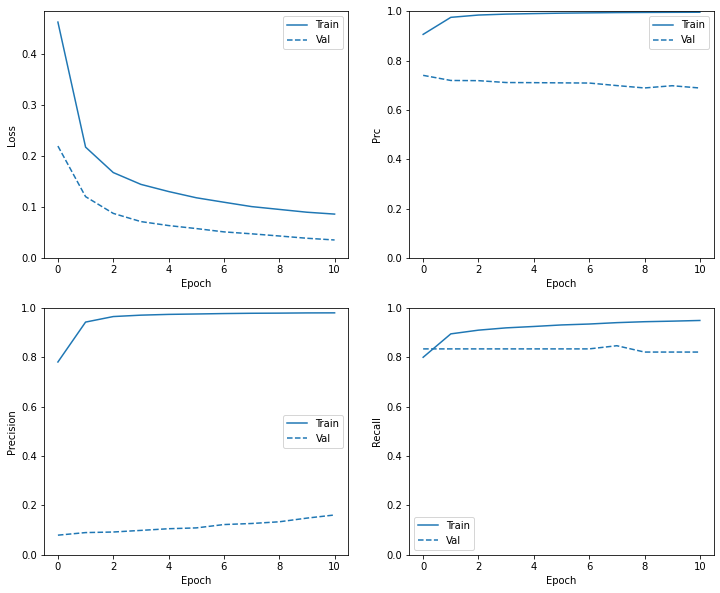

In [ ]:
plot_metrics(oversampled_history)

## Train using EarlyStopping against overfitting


In [ ]:
oversampled_model = make_model()
oversampled_model.load_weights(initial_weights) # Reset bias to zero, given balanced dataset

output_layer = oversampled_model.layers[-1] 
output_layer.bias.assign([0])

oversampled_history = oversampled_model.fit(resampled_ds,
                                            epochs=10*EPOCHS,
                                            steps_per_epoch=20,
                                            callbacks=[early_stopping],
                                            validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 5s 142ms/step - loss: 1.1920 - tp: 8495.0000 - fp: 8473.0000 - tn: 57543.0000 - fn: 12018.0000 - accuracy: 0.7632 - precision: 0.5006 - recall: 0.4141 - auc: 0.7841 - prc: 0.5594 - val_loss: 0.6069 - val_tp: 56.0000 - val_fp: 15276.0000 - val_tn: 30215.0000 - val_fn: 22.0000 - val_accuracy: 0.6643 - val_precision: 0.0037 - val_recall: 0.7179 - val_auc: 0.7756 - val_prc: 0.3164
Epoch 2/1000
20/20 [==============================] - 2s 93ms/step - loss: 0.7349 - tp: 13645.0000 - fp: 8184.0000 - tn: 12162.0000 - fn: 6969.0000 - accuracy: 0.6301 - precision: 0.6251 - recall: 0.6619 - auc: 0.6993 - prc: 0.7833 - val_loss: 0.5838 - val_tp: 63.0000 - val_fp: 14187.0000 - val_tn: 31304.0000 - val_fn: 15.0000 - val_accuracy: 0.6883 - val_precision: 0.0044 - val_recall: 0.8077 - val_auc: 0.8623 - val_prc: 0.5461
Epoch 3/1000
20/20 [==============================] - 2s 89ms/step - loss: 0.5797 - tp: 15653.0000 - fp: 7758.0000 - tn: 12787.0000 -

## Replot history

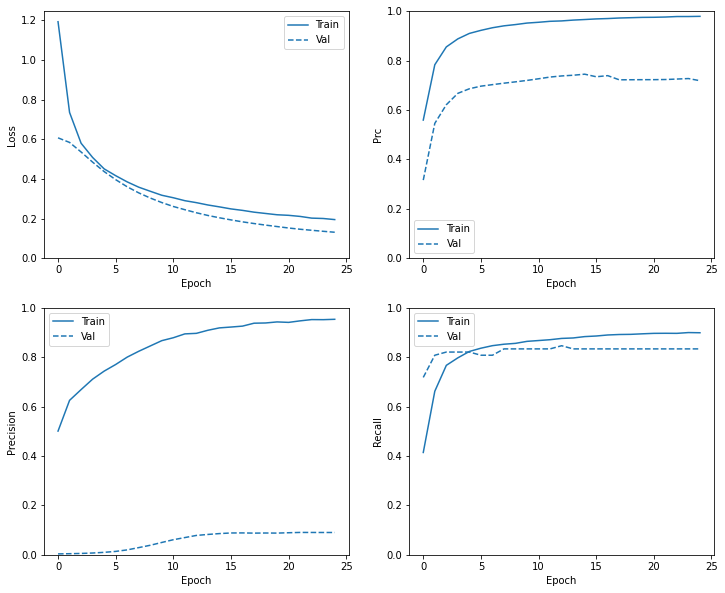

In [ ]:
plot_metrics(oversampled_history)

## Evaluate metrics

In [ ]:
train_preds_oversampled = oversampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_preds_oversampled = oversampled_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 5ms/step


loss :  0.20322652161121368
tp :  86.0
fp :  862.0
tn :  56003.0
fn :  11.0
accuracy :  0.9846739768981934
precision :  0.09071730077266693
recall :  0.8865979313850403
auc :  0.9802260398864746
prc :  0.7235668301582336

Legitimate Transactions Detected (True Negatives):  56003
Legitimate Transactions Incorrectly Detected (False Positives):  862
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  86
Total Fraudulent Transactions:  97


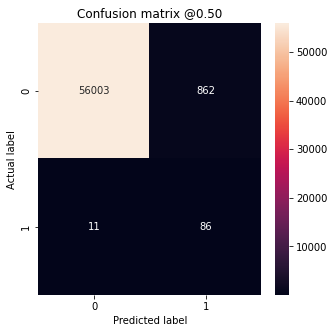

In [ ]:
resampled_results = oversampled_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(oversampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_preds_oversampled)

## Compare ROCs

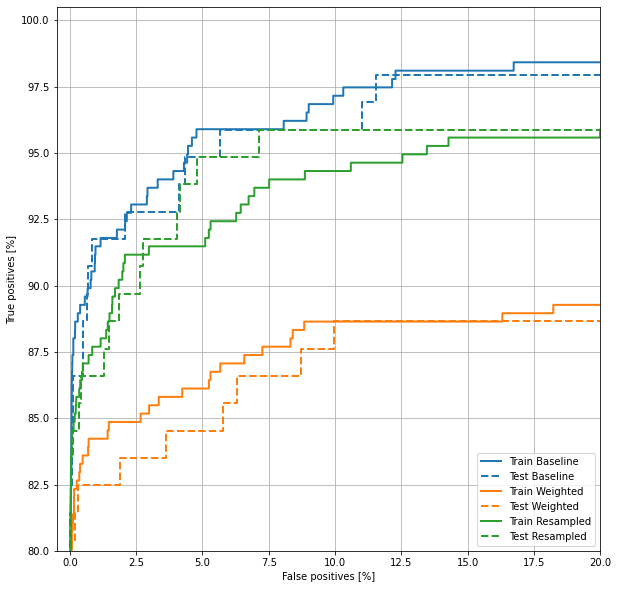

In [ ]:
plot_roc("Train Baseline", train_labels, train_preds, color=colors[0])
plot_roc("Test Baseline", test_labels, test_preds, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_preds_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_preds_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_preds_oversampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_preds_oversampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## Compare AUPRC


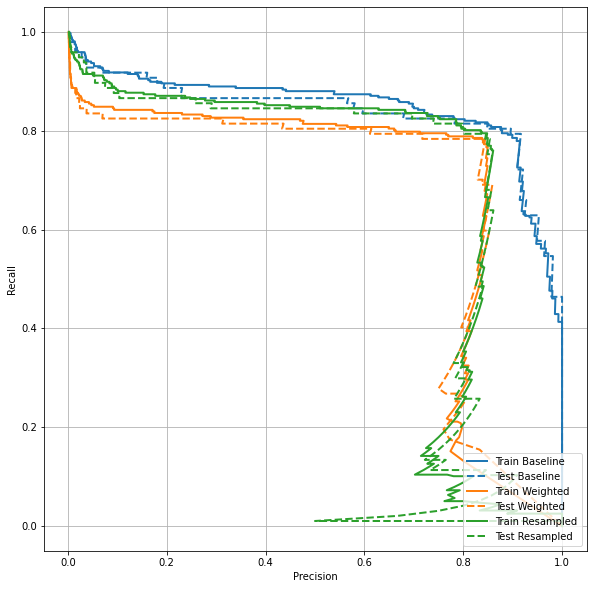

In [ ]:
plot_prc("Train Baseline", train_labels, train_preds, color=colors[0])
plot_prc("Test Baseline", test_labels, test_preds, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_preds_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_preds_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_preds_oversampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_preds_oversampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

# References
Codes from TensorFlow.org.